In [3]:
import numpy as np
import re
print(np.__version__)
import os
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras import datasets, layers, models 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')

import sklearn as sk
from sklearn.model_selection import train_test_split
from data_split import data_separator, get_oversampling
from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

1.23.5
2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15000)])
  except RuntimeError as e:
      print(e)

In [5]:
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
!nvidia-smi

/bin/bash: /home/12559743/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Oct 31 13:39:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P5000                   Off | 00000000:3B:00.0 Off |                  Off |
| 26%   35C    P8               6W / 180W |      9MiB / 16384MiB |      0%      Default |
|                                    

In [7]:
df = pd.read_csv('df_cropped.csv')
#del df['Unnamed: 0']
#df = df.sample(frac = 1, random_state=2023).reset_index(drop=True)
df = df.dropna(axis=0)
print(len(df))
df.head()

1046


,Unnamed: 0,Patient,Sex,Date of birth,PAN Date,Age at PAN,PAN Path
0,0,SEBASTIAO ABAQUI,M,24/05/1943,25/10/2016,74.0,/home/12559743/DAVI/todos_pacientes/ABAQUI SEB...
1,1,ABEGAIR SOUZA SILVA,M,03/03/1981,28/09/2018,38.0,/home/12559743/DAVI/todos_pacientes/ABEGAIR SO...
2,2,ABEL GONCALVES DA CUNHA,M,01/03/1970,05/10/2016,47.0,/home/12559743/DAVI/todos_pacientes/ABEL GONÇA...
3,3,ABELARDO RODRIGUES DA SILVA,M,04/01/1977,13/11/2018,42.0,/home/12559743/DAVI/todos_pacientes/ABELARDO R...
4,4,JOSE BENEDITO DE ABREU,M,29/09/1938,13/04/2016,78.0,/home/12559743/DAVI/todos_pacientes/ABREU JOSE...


(array([  4.,  13.,  30.,  32., 126., 203., 170., 251., 189.,  28.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <BarContainer object of 10 artists>)

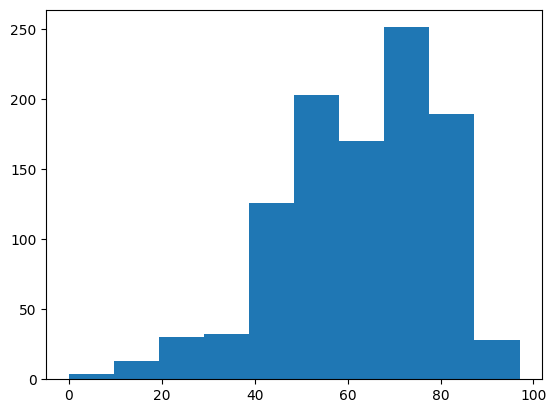

In [8]:
plt.hist(df['Age at PAN'])

In [9]:
df.describe()

,Unnamed: 0,Age at PAN
count,1046.000000,1046.000000
mean,522.806883,62.563098
std,302.467215,16.694019
min,0.000000,0.000000
25%,261.250000,52.000000
50%,522.500000,65.000000
75%,784.750000,75.000000
max,1046.000000,97.000000


for i in range(len(df)):
    df.at[i,'PAN Path'] = str(df.at[i, 'PAN Path']).replace('E:\DAVI\todos_pacientes', '/home/12559743/DAVI/todos_pacientes')
    print(df.at[i, 'PAN Path'])
    break


In [10]:
# old_path = list(df['PAN Path'])
# new_path = [p.replace('.BMP', '.png') for p in old_path]
# #new_path = [p.replace('\\', '/') for p in new_path]
# df['PAN Path'] = new_path

In [11]:
df.head()

,Unnamed: 0,Patient,Sex,Date of birth,PAN Date,Age at PAN,PAN Path
0,0,SEBASTIAO ABAQUI,M,24/05/1943,25/10/2016,74.0,/home/12559743/DAVI/todos_pacientes/ABAQUI SEB...
1,1,ABEGAIR SOUZA SILVA,M,03/03/1981,28/09/2018,38.0,/home/12559743/DAVI/todos_pacientes/ABEGAIR SO...
2,2,ABEL GONCALVES DA CUNHA,M,01/03/1970,05/10/2016,47.0,/home/12559743/DAVI/todos_pacientes/ABEL GONÇA...
3,3,ABELARDO RODRIGUES DA SILVA,M,04/01/1977,13/11/2018,42.0,/home/12559743/DAVI/todos_pacientes/ABELARDO R...
4,4,JOSE BENEDITO DE ABREU,M,29/09/1938,13/04/2016,78.0,/home/12559743/DAVI/todos_pacientes/ABREU JOSE...


In [12]:
df.columns

Index(['Unnamed: 0', 'Patient', 'Sex', 'Date of birth', 'PAN Date',
       'Age at PAN', 'PAN Path'],
      dtype='object')

In [13]:
print(df.iloc[5]['Patient'], df.iloc[5]['PAN Date'], df.iloc[5]['PAN Path'])

JOSE BENEDITO DE ABREU 16/01/2018 /home/12559743/DAVI/todos_pacientes/ABREU JOSE BENEDITO DE/JOSE BENEDITO DE ABREU- -- - - - 29-09-1938- PX from 16-01-2018 S0 I0(1)_cr.jpg


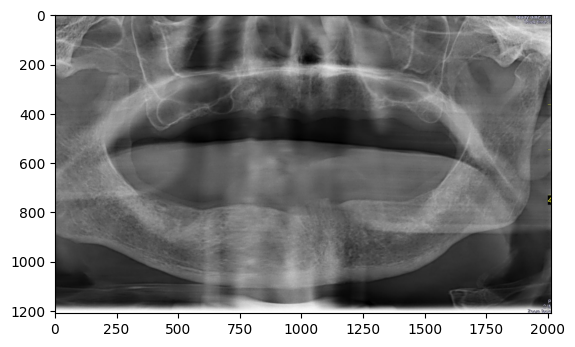

In [14]:
img = plt.imread(df.iloc[5]['PAN Path'])
plt.imshow(img)

Criando treino, Teste e Validacao por classe

Primerio iremos tratar de Regressao

In [15]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)

print(len(train), len(val), len(test))

836 105 105


In [16]:
train_list = (list(train['PAN Path']), list(train['Age at PAN']))
val_list = (list(val['PAN Path']), list(val['Age at PAN']))
test_list = (list(test['PAN Path']), list(test['Age at PAN']))

print(len(train), len(val), len(test))

836 105 105


In [17]:
print(train_list[0][100], train_list[1][100])
path = train_list[0][100]
df[df['PAN Path'] ==path]['Age at PAN']

/home/12559743/DAVI/todos_pacientes/DIAS MARIA APARECIDA/MARIA APARECIDA DIAS- -- - - - 23-06-1964- PX from 23-11-2015 S0 I0(1)_cr.jpg 52.0


420    52.0
Name: Age at PAN, dtype: float64

In [18]:
from itertools import repeat

#train
input_shape = (224,224,3)

image_list_train = list(map(load_and_preprocess_image, train_list[0], repeat('jpg'), repeat(input_shape)))
train_dataset = generate_path_dataset(image_list_train, train_list[1]).shuffle(len(image_list_train), seed=42)

#validation

image_list_val = list(map(load_and_preprocess_image, val_list[0], repeat('jpg'), repeat(input_shape)))
val_dataset = generate_path_dataset(image_list_val, val_list[1]).shuffle(len(image_list_val), seed=42)

#test

image_list_test = list(map(load_and_preprocess_image, test_list[0], repeat('jpg'), repeat(input_shape)))
test_dataset = generate_path_dataset(image_list_val, test_list[1]).shuffle(len(image_list_val), seed=42)

2023-10-31 13:39:51.952254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 13:39:52.650093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15000 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:3b:00.0, compute capability: 6.1


(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

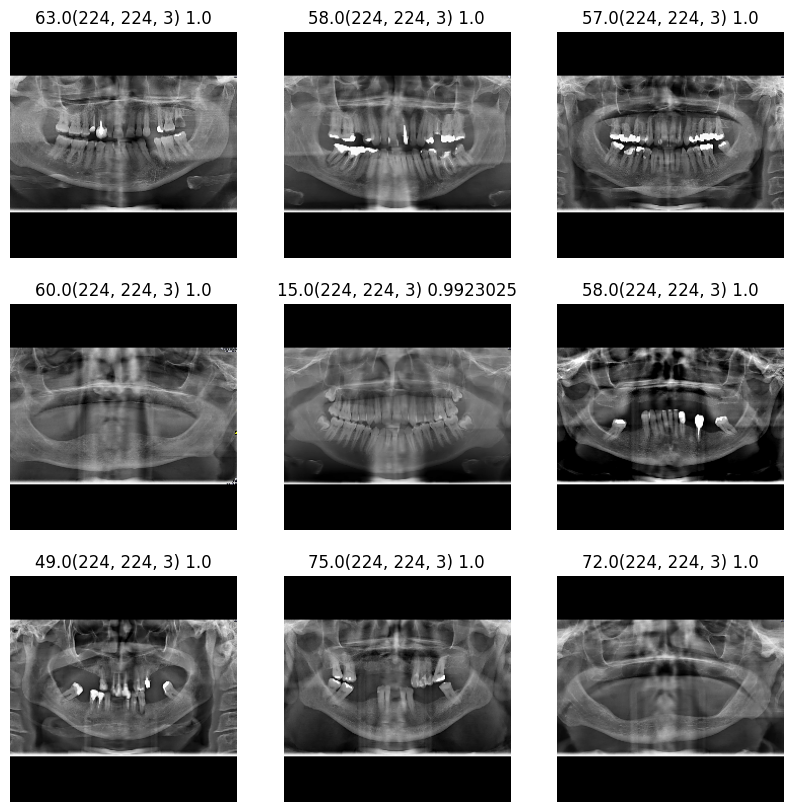

In [19]:
plt.figure(figsize=(10, 10))
i = 0
for pairs in train_dataset:
    ax = plt.subplot(3, 3, i + 1)
    #print('Max',pairs[0].numpy().max(),'Shape', pairs[0].numpy().shape)
    plt.imshow(pairs[0], cmap='gray')
    plt.title(str(pairs[1].numpy()) + str(pairs[0].shape) + ' ' + str(pairs[0].numpy().max()))
    plt.axis("off")
    
    i += 1
    if i == 9:
        break

In [19]:
def r2_score_(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true,y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.math.divide(residual,total))
    return r2

In [20]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [22]:
drop_prob = 0.2
model = keras.Sequential([
    tf.keras.layers.Input((224,224,3)),
 #   tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(224,224,3),
#                                           include_top=False, weights='imagenet'),
    tf.keras.layers.Conv2D(filters = 6, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 4, kernel_size=(3,3), padding='same', activation='relu'),
    
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters = 2, kernel_size=(3,3), padding='same', activation= 'relu'),
    tf.keras.layers.Conv2D(filters = 2, kernel_size=(3,3), padding='same', activation='relu'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1280, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(1, activation='relu'),
])

In [68]:
def r2_score(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true,y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.math.divide(residual,total))
    return r2

In [23]:
model.compile(optimizer='Adam', loss = 'mse', metrics=['mae', rmse])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 6)       168       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 4)       220       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 4)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 2)       74        
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 2)       38        
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                        

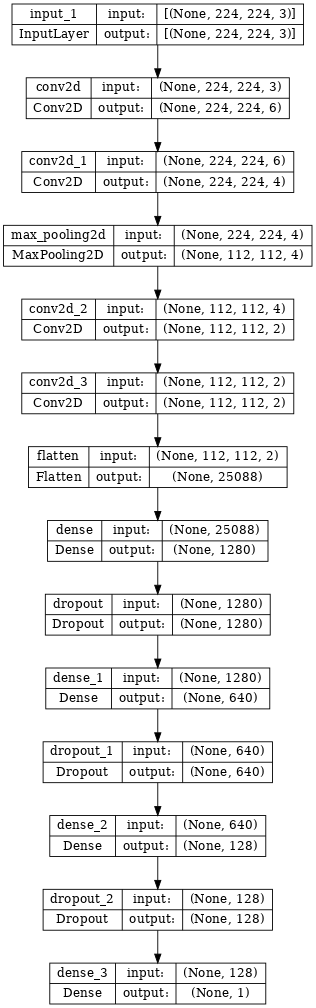

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 64)

In [26]:
exp_path= r'/home/12559743/DAVI/IC/Codes'
exp_name = 'regression_age_create_efficientnet'

checkpoint_path = os.path.join(exp_path, exp_name + '/cp-{epoch:04d}.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor = 'val_mse',
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     mode='max',
                                                     verbose=1)

log_dir = exp_path+exp_name+'/log/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [27]:
train_data_used = train_dataset
val_data_used = val_dataset

BUFFER_SIZE = len(train_data_used)
BATCH_SIZE = 4


tf.keras.backend.clear_session()


train_acc = []
val_acc = []
train_loss = []
val_loss = []

train_data = train_data_used.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_data_used.cache().shuffle(len(val_data_used)).batch(BATCH_SIZE)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    monitor = 'val_root_mean_squared_error',
                                                    save_best_only = True,
                                                    save_weights_only=True,
                                                    mode='min',
                                                    verbose=1)

log_dir = exp_path+exp_name+'/log/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[cp_callback,tb_callback])

Epoch 1/100


2023-09-11 17:45:43.749059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-09-11 17:45:44.070821: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-11 17:45:44.074171: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-11 17:45:44.074207: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-11 17:45:44.077621: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-11 17:45:44.077718: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


209/209 [==============================] - ETA: 0s - loss: 507.4482 - mae: 17.4708 - root_mean_squared_error: 22.5266
Epoch 1: val_root_mean_squared_error improved from inf to 17.60579, saving model to /home/12559743/DAVI/IC/Codes/regression_age_create_efficientnet/cp-0001.ckpt
209/209 [==============================] - 127s 425ms/step - loss: 507.4482 - mae: 17.4708 - root_mean_squared_error: 22.5266 - val_loss: 309.9640 - val_mae: 14.9168 - val_root_mean_squared_error: 17.6058
Epoch 2/100
209/209 [==============================] - ETA: 0s - loss: 369.7024 - mae: 15.4295 - root_mean_squared_error: 19.2276
Epoch 2: val_root_mean_squared_error did not improve from 17.60579
209/209 [==============================] - 74s 353ms/step - loss: 369.7024 - mae: 15.4295 - root_mean_squared_error: 19.2276 - val_loss: 337.1527 - val_mae: 14.1026 - val_root_mean_squared_error: 18.3617
Epoch 3/100
209/209 [==============================] - ETA: 0s - loss: 383.6120 - mae: 15.2641 - root_mean_squared_

Epoch 20/100
209/209 [==============================] - ETA: 0s - loss: 284.2031 - mae: 13.2420 - root_mean_squared_error: 16.8583
Epoch 20: val_root_mean_squared_error did not improve from 12.96977
209/209 [==============================] - 74s 352ms/step - loss: 284.2031 - mae: 13.2420 - root_mean_squared_error: 16.8583 - val_loss: 174.5965 - val_mae: 10.6717 - val_root_mean_squared_error: 13.2135
Epoch 21/100
209/209 [==============================] - ETA: 0s - loss: 243.1524 - mae: 12.2820 - root_mean_squared_error: 15.5933
Epoch 21: val_root_mean_squared_error improved from 12.96977 to 11.31829, saving model to /home/12559743/DAVI/IC/Codes/regression_age_create_efficientnet/cp-0021.ckpt
209/209 [==============================] - 79s 380ms/step - loss: 243.1524 - mae: 12.2820 - root_mean_squared_error: 15.5933 - val_loss: 128.1038 - val_mae: 8.5747 - val_root_mean_squared_error: 11.3183
Epoch 22/100
209/209 [==============================] - ETA: 0s - loss: 252.2271 - mae: 12.4106 

Epoch 40/100
209/209 [==============================] - ETA: 0s - loss: 280.0105 - mae: 13.2775 - root_mean_squared_error: 16.7335
Epoch 40: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 353ms/step - loss: 280.0105 - mae: 13.2775 - root_mean_squared_error: 16.7335 - val_loss: 173.3996 - val_mae: 10.9535 - val_root_mean_squared_error: 13.1681
Epoch 41/100
209/209 [==============================] - ETA: 0s - loss: 244.2293 - mae: 12.2830 - root_mean_squared_error: 15.6278
Epoch 41: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 353ms/step - loss: 244.2293 - mae: 12.2830 - root_mean_squared_error: 15.6278 - val_loss: 296.9801 - val_mae: 14.6111 - val_root_mean_squared_error: 17.2331
Epoch 42/100
209/209 [==============================] - ETA: 0s - loss: 238.3232 - mae: 12.1692 - root_mean_squared_error: 15.4377
Epoch 42: val_root_mean_squared_error did not improve from 10.4

209/209 [==============================] - 74s 354ms/step - loss: 205.6644 - mae: 11.2651 - root_mean_squared_error: 14.3410 - val_loss: 267.7279 - val_mae: 13.9756 - val_root_mean_squared_error: 16.3624
Epoch 61/100
209/209 [==============================] - ETA: 0s - loss: 195.8143 - mae: 10.9973 - root_mean_squared_error: 13.9934
Epoch 61: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 354ms/step - loss: 195.8143 - mae: 10.9973 - root_mean_squared_error: 13.9934 - val_loss: 172.8021 - val_mae: 9.6761 - val_root_mean_squared_error: 13.1454
Epoch 62/100
209/209 [==============================] - ETA: 0s - loss: 219.9382 - mae: 11.7206 - root_mean_squared_error: 14.8303
Epoch 62: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 354ms/step - loss: 219.9382 - mae: 11.7206 - root_mean_squared_error: 14.8303 - val_loss: 797.2986 - val_mae: 24.9013 - val_root_mean_squared_error:

Epoch 81/100
209/209 [==============================] - ETA: 0s - loss: 147.4250 - mae: 9.5978 - root_mean_squared_error: 12.1419
Epoch 81: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 354ms/step - loss: 147.4250 - mae: 9.5978 - root_mean_squared_error: 12.1419 - val_loss: 177.1978 - val_mae: 10.8693 - val_root_mean_squared_error: 13.3116
Epoch 82/100
209/209 [==============================] - ETA: 0s - loss: 151.4666 - mae: 9.6496 - root_mean_squared_error: 12.3072
Epoch 82: val_root_mean_squared_error did not improve from 10.42658
209/209 [==============================] - 74s 354ms/step - loss: 151.4666 - mae: 9.6496 - root_mean_squared_error: 12.3072 - val_loss: 133.3587 - val_mae: 9.1543 - val_root_mean_squared_error: 11.5481
Epoch 83/100
209/209 [==============================] - ETA: 0s - loss: 149.3707 - mae: 9.6748 - root_mean_squared_error: 12.2217
Epoch 83: val_root_mean_squared_error did not improve from 10.42658
2

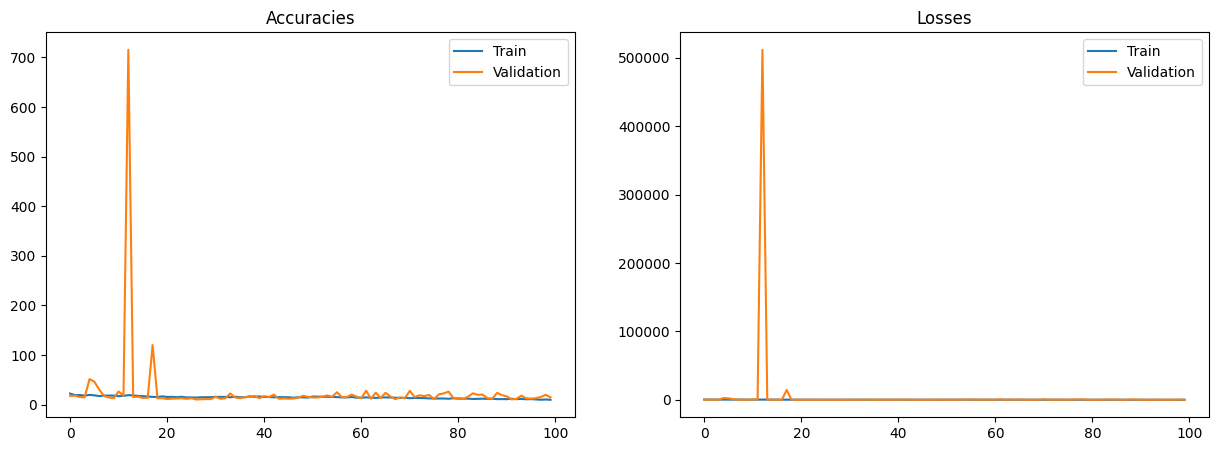

In [28]:
plot_model_history(history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error'],
                  history.history['loss'], history.history['val_loss'])

In [25]:
#efficient_reload =start_model(choice_model='efficientnetv2', choice_opt='Adam', loss='mean_absolute_error',
                        #pred_acticvation='relu', metrics= ['mae', rmse])

experiment_path = r'/home/12559743/DAVI/IC/Codes/'
experiment_name = 'regression_age_create_efficient_new/'

best_cp = 'cp-0088.ckpt'

checkpoint_path = os.path.join(experiment_path, experiment_name)
path_weight = os.path.join(checkpoint_path, best_cp)
model.load_weights(path_weight)

In [26]:
# for train dataset
#model = efficient_reload
y_true_train, y_pred_train = get_dataset_prediction(train_dataset, model)
#evaluate_prediction(y_true, y_pred)

2023-10-31 13:41:57.019734: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step
53 54.0
1/1 [==============================] - 0s 24ms/step
83 79.0
1/1 [==============================] - 0s 22ms/step
88 79.0
1/1 [==============================] - 0s 23ms/step
68 68.0
1/1 [==============================] - 0s 23ms/step
53 56.0
1/1 [==============================] - 0s 26ms/step
94 91.0
1/1 [==============================] - 0s 24ms/step
58 58.0
1/1 [==============================] - 0s 23ms/step
79 77.0
1/1 [==============================] - 0s 23ms/step
49 51.0
1/1 [==============================] - 0s 23ms/step
66 63.0
1/1 [==============================] - 0s 25ms/step
74 72.0
1/1 [==============================] - 0s 25ms/step
86 87.0
1/1 [==============================] - 0s 24ms/step
53 54.0
1/1 [==============================] - 0s 24ms/step
77 75.0
1/1 [==============================] - 0s 23ms/step
84 84.0
1/1 [==============================] - 0s 28ms/step
44 42.0
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 23ms/step
78 79.0
1/1 [==============================] - 0s 22ms/step
78 71.0
1/1 [==============================] - 0s 23ms/step
49 47.0
1/1 [==============================] - 0s 23ms/step
54 53.0
1/1 [==============================] - 0s 25ms/step
39 41.0
1/1 [==============================] - 0s 23ms/step
77 74.0
1/1 [==============================] - 0s 23ms/step
67 65.0
1/1 [==============================] - 0s 23ms/step
78 74.0
1/1 [==============================] - 0s 24ms/step
80 79.0
1/1 [==============================] - 0s 23ms/step
76 73.0
1/1 [==============================] - 0s 24ms/step
70 67.0
1/1 [==============================] - 0s 22ms/step
46 48.0
1/1 [==============================] - 0s 22ms/step
71 72.0
1/1 [==============================] - 0s 22ms/step
99 86.0
1/1 [==============================] - 0s 24ms/step
60 59.0
1/1 [==============================] - 0s 22ms/step
71 72.0
1/1 [==============================] - 0

1/1 [==============================] - 0s 23ms/step
34 32.0
1/1 [==============================] - 0s 24ms/step
63 60.0
1/1 [==============================] - 0s 23ms/step
65 65.0
1/1 [==============================] - 0s 23ms/step
58 63.0
1/1 [==============================] - 0s 23ms/step
86 86.0
1/1 [==============================] - 0s 25ms/step
74 77.0
1/1 [==============================] - 0s 23ms/step
77 76.0
1/1 [==============================] - 0s 22ms/step
53 55.0
1/1 [==============================] - 0s 23ms/step
70 69.0
1/1 [==============================] - 0s 22ms/step
71 69.0
1/1 [==============================] - 0s 23ms/step
86 82.0
1/1 [==============================] - 0s 26ms/step
34 30.0
1/1 [==============================] - 0s 23ms/step
64 66.0
1/1 [==============================] - 0s 23ms/step
80 76.0
1/1 [==============================] - 0s 24ms/step
46 51.0
1/1 [==============================] - 0s 21ms/step
83 78.0
1/1 [==============================] - 0

1/1 [==============================] - 0s 25ms/step
74 73.0
1/1 [==============================] - 0s 26ms/step
72 74.0
1/1 [==============================] - 0s 26ms/step
56 57.0
1/1 [==============================] - 0s 29ms/step
75 72.0
1/1 [==============================] - 0s 23ms/step
52 54.0
1/1 [==============================] - 0s 27ms/step
47 49.0
1/1 [==============================] - 0s 26ms/step
82 82.0
1/1 [==============================] - 0s 26ms/step
46 47.0
1/1 [==============================] - 0s 24ms/step
71 72.0
1/1 [==============================] - 0s 26ms/step
77 73.0
1/1 [==============================] - 0s 25ms/step
57 57.0
1/1 [==============================] - 0s 30ms/step
21 20.0
1/1 [==============================] - 0s 24ms/step
44 41.0
1/1 [==============================] - 0s 26ms/step
73 75.0
1/1 [==============================] - 0s 24ms/step
55 59.0
1/1 [==============================] - 0s 26ms/step
37 35.0
1/1 [==============================] - 0

In [27]:
#for val dataset
y_true_val, y_pred_val = get_dataset_prediction(val_dataset, model)
#evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 25ms/step
56 64.0
1/1 [==============================] - 0s 24ms/step
64 65.0
1/1 [==============================] - 0s 25ms/step
56 76.0
1/1 [==============================] - 0s 24ms/step
58 56.0
1/1 [==============================] - 0s 25ms/step
62 76.0
1/1 [==============================] - 0s 26ms/step
71 81.0
1/1 [==============================] - 0s 24ms/step
71 75.0
1/1 [==============================] - 0s 24ms/step
45 58.0
1/1 [==============================] - 0s 24ms/step
46 41.0
1/1 [==============================] - 0s 23ms/step
78 71.0
1/1 [==============================] - 0s 24ms/step
76 73.0
1/1 [==============================] - 0s 25ms/step
62 67.0
1/1 [==============================] - 0s 26ms/step
69 53.0
1/1 [==============================] - 0s 25ms/step
52 42.0
1/1 [==============================] - 0s 23ms/step
41 38.0
1/1 [==============================] - 0s 26ms/step
59 66.0
1/1 [==============================] - 0

In [28]:
#for test dataset
y_true_test, y_pred_test = get_dataset_prediction(test_dataset, model)
#evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 23ms/step
56 47.0
1/1 [==============================] - 0s 25ms/step
64 45.0
1/1 [==============================] - 0s 26ms/step
56 78.0
1/1 [==============================] - 0s 21ms/step
58 76.0
1/1 [==============================] - 0s 37ms/step
62 55.0
1/1 [==============================] - 0s 23ms/step
71 68.0
1/1 [==============================] - 0s 24ms/step
71 71.0
1/1 [==============================] - 0s 26ms/step
45 30.0
1/1 [==============================] - 0s 24ms/step
46 79.0
1/1 [==============================] - 0s 23ms/step
78 82.0
1/1 [==============================] - 0s 24ms/step
76 78.0
1/1 [==============================] - 0s 23ms/step
62 73.0
1/1 [==============================] - 0s 24ms/step
69 49.0
1/1 [==============================] - 0s 25ms/step
52 70.0
1/1 [==============================] - 0s 23ms/step
41 54.0
1/1 [==============================] - 0s 22ms/step
59 67.0
1/1 [==============================] - 0

In [ ]:
y_true_train, y_pred_train=get_dataset_prediction(test_dataset, model)

1/1 [==============================] - 0s 24ms/step


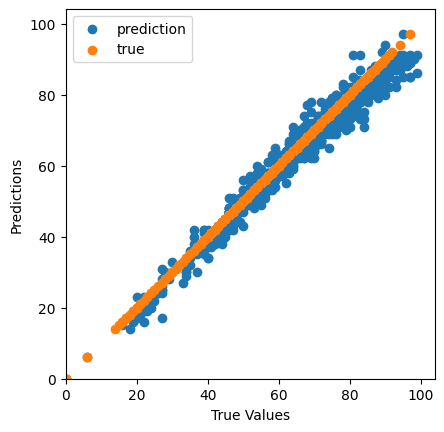

In [33]:
# Assuming test_dataset is a ShuffleDataset and contains multiple data points
# Extract a single data point from the dataset (you may need to use a loop if needed)
sample_data, _ = next(iter(test_dataset))

# Convert the extracted data point to a NumPy array
sample_data_np = sample_data.numpy()

# Expand the dimensions and predict
test_prediction = model.predict(np.expand_dims(sample_data_np, axis=0)).flatten()

plt.scatter(y_pred, y_true, label='prediction') #marker=CARETDOWNBASE
#plt.scatter(y_true,y_true, label='true')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])
plt.legend()



In [33]:
test_prediction

array([78.58154], dtype=float32)

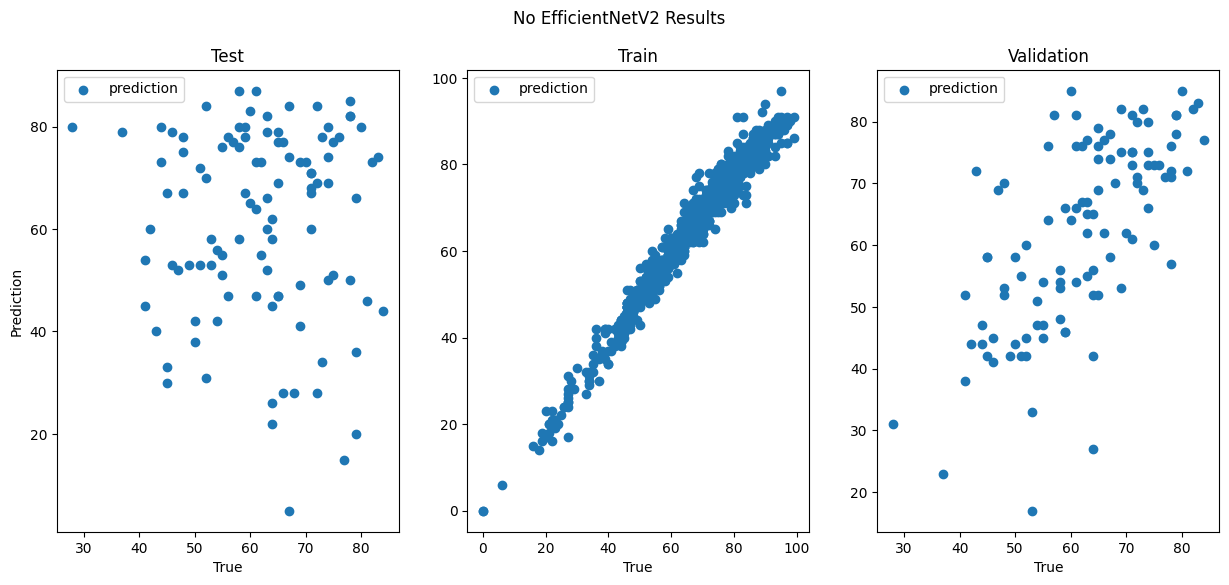

In [31]:
fig, axs = plt.subplots(1,3, figsize = (15,6))

axs[0].set_title('Test')
axs[0].scatter(y_pred_test, y_true_test, label = 'prediction')
#axs[0].scatter(y_true_test,y_true_test, label='true')
axs[0].legend()
axs[0].set_ylabel('Prediction')
axs[0].set_xlabel('True')

axs[1].set_title('Train')
axs[1].scatter(y_pred_train, y_true_train, label = 'prediction')
#axs[1].scatter(y_true_train,y_true_train, label='true')
axs[1].legend()
axs[1].set_xlabel('True')

axs[2].set_title('Validation')
axs[2].scatter(y_pred_val, y_true_val, label = 'prediction')
#axs[2].scatter(y_true_val,y_true_val, label='true')
axs[2].legend()
axs[2].set_xlabel('True')

fig.suptitle('No EfficientNetV2 Results')

plt.savefig('No_EfficientNetV2_regression.jpg')

plt.show()